In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score

Inizializzazione dei dataset di train e test sulla base dei file "train.csv" e "test.csv" preparati tramite l'apposito notebook e caricamento del CSV da utilizzare come tabella di lookup per integrare le informazioni all'interno dei dataset.

In [3]:
train_set_original=pd.read_csv("train.csv")
test_set_original=pd.read_csv("test.csv")

poke_stats_dataset = pd.read_csv('pokemon.csv')

Definizione di una funzione per eliminare colonne da entrambi i dataframe.

In [4]:
def drop_columns(datasets: list, columns: list):
    for dataset in datasets:
        for column in columns:
            dataset.drop(columns=[f'{column}_fst', f'{column}_snd'], inplace = True, axis = 1)

Integrazione dei dataset di train e test con la tabella di lookup ed eliminazione dei parametri superflui (#_fst, #_snd). Infatti l'operazione di merge ha prodotto inevitabilmente della ridondanza. I restanti valori duplicati (differenziabili attraverso i suffissi "_fst" e "_snd") saranno necessari per aggiungere delle feature di comparazione tra statistiche, come spiegato successivamente.

In [5]:
train_set = train_set_original.merge(poke_stats_dataset, left_on='First_pokemon', right_on='#')
train_set = train_set.merge(poke_stats_dataset, left_on='Second_pokemon', right_on='#', suffixes=('_fst', '_snd'))

test_set = test_set_original.merge(poke_stats_dataset, left_on='First_pokemon', right_on='#')
test_set = test_set.merge(poke_stats_dataset, left_on='Second_pokemon', right_on='#', suffixes=('_fst', '_snd'))

drop_columns([train_set, test_set], ['#'])

Ispeziono il dataset di train così ottenuto.

In [6]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Name_fst,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,405,405,585,Relicanth,Water,Rock,100,90,130,45,...,Rock,NaN,70,105,105,50,40,20,5,False
1,667,667,585,Elgyem,Psychic,NaN,55,55,55,85,...,Rock,NaN,70,105,105,50,40,20,5,False
2,422,422,585,Kyogre,Water,NaN,100,100,90,150,...,Rock,NaN,70,105,105,50,40,20,5,False
3,409,409,585,Salamence,Dragon,Flying,95,135,80,110,...,Rock,NaN,70,105,105,50,40,20,5,False
4,585,671,585,Chandelure,Ghost,Fire,60,55,90,145,...,Rock,NaN,70,105,105,50,40,20,5,False


In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Winner          32000 non-null  int64 
 1   First_pokemon   32000 non-null  int64 
 2   Second_pokemon  32000 non-null  int64 
 3   Name_fst        31961 non-null  object
 4   Type 1_fst      32000 non-null  object
 5   Type 2_fst      16578 non-null  object
 6   HP_fst          32000 non-null  int64 
 7   Attack_fst      32000 non-null  int64 
 8   Defense_fst     32000 non-null  int64 
 9   Sp. Atk_fst     32000 non-null  int64 
 10  Sp. Def_fst     32000 non-null  int64 
 11  Speed_fst       32000 non-null  int64 
 12  Generation_fst  32000 non-null  int64 
 13  Legendary_fst   32000 non-null  bool  
 14  Name_snd        31974 non-null  object
 15  Type 1_snd      32000 non-null  object
 16  Type 2_snd      16670 non-null  object
 17  HP_snd          32000 non-null  int64 
 18  Attack

Si osserva che i campi "Name_fst", "Name_snd", "Type_2_fst" e "Type_2_snd" possiedono dei valori nulli.

Ad intuito:
- Considerato il contesto di battaglie tra pokémon, le feature relative al nome del pokémon non hanno rilevanza.
- Il "tipo" del pokémon sembra invece poter essere una feature rilevante ai fini della classificazione.

Date le considerazioni sopra effettuate, rimuovo le prime due feature, mentre sostituisco le seconde due con il loro rispettivo "Type_1", in modo tale da cercare di simulare la presenza di un secondo tipo.

Le soluzioni alternative, come l'aggiunta di un tipo "fantoccio" oppure eliminare completamente la colonna relativa al secondo tipo sono state scartate, in quanto la prima avrebbe potuto introdurre troppo rumore e la seconda avrebbe potuto potenzialmente eliminare delle informazioni utili alla classificazione.

In [8]:
drop_columns([train_set, test_set], ['Name'])

In [9]:
# sostituisce eventuali valori nulli del secondo tipo con quelli del primo
train_set['Type 2_fst'] = train_set.apply(lambda x: x['Type 1_fst'] if pd.isnull(x['Type 2_fst']) else x['Type 2_fst'], axis = 1)
train_set['Type 2_snd'] = train_set.apply(lambda x: x['Type 1_snd'] if pd.isnull(x['Type 2_snd']) else x['Type 2_snd'], axis = 1)

test_set['Type 2_fst'] = train_set.apply(lambda x: x['Type 1_fst'] if pd.isnull(x['Type 2_fst']) else x['Type 2_fst'], axis = 1)
test_set['Type 2_snd'] = train_set.apply(lambda x: x['Type 1_snd'] if pd.isnull(x['Type 2_snd']) else x['Type 2_snd'], axis = 1)

Imposto il problema come un problema di classificazione binaria, dove la label da prevedere è "Winner" e risponde alla domanda "Il primo pokémon vince lo scontro?". Se la rispostà è sì, avrà valore 1, 0 altrimenti.

In [10]:
def calc_binary_label (label_id, first_id, second_id):
    if (label_id == first_id):
        return 1
    else:
        return 0

train_set['Winner'] = train_set.apply(lambda x: calc_binary_label(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis = 1)
test_set['Winner'] = test_set.apply(lambda x: calc_binary_label(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis = 1)

In [11]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,1,405,585,Water,Rock,100,90,130,45,65,...,Rock,Rock,70,105,105,50,40,20,5,False
1,1,667,585,Psychic,Psychic,55,55,55,85,55,...,Rock,Rock,70,105,105,50,40,20,5,False
2,1,422,585,Water,Water,100,100,90,150,140,...,Rock,Rock,70,105,105,50,40,20,5,False
3,1,409,585,Dragon,Flying,95,135,80,110,80,...,Rock,Rock,70,105,105,50,40,20,5,False
4,0,671,585,Ghost,Fire,60,55,90,145,90,...,Rock,Rock,70,105,105,50,40,20,5,False


Effettuo un label encoding sulle feature sotto elencate. Operazione necessaria al fine di poter utilizzare i dati per la costruzione del decision tree classifier. 

In [12]:
encoded_features = ['Type 1_fst', 'Type 2_fst','Legendary_fst', 'Type 1_snd', 'Type 2_snd', 'Legendary_snd']
encoder = preprocessing.LabelEncoder()

for e in encoded_features:
    train_set[e] = encoder.fit_transform(train_set[e])
    test_set[e] = encoder.fit_transform(test_set[e])

train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,1,405,585,17,15,100,90,130,45,65,...,15,15,70,105,105,50,40,20,5,0
1,1,667,585,14,14,55,55,55,85,55,...,15,15,70,105,105,50,40,20,5,0
2,1,422,585,17,17,100,100,90,150,140,...,15,15,70,105,105,50,40,20,5,0
3,1,409,585,2,7,95,135,80,110,80,...,15,15,70,105,105,50,40,20,5,0
4,0,671,585,8,6,60,55,90,145,90,...,15,15,70,105,105,50,40,20,5,0


In [13]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,1,405,585,17,15,100,90,130,45,65,...,15,15,70,105,105,50,40,20,5,0
1,1,667,585,14,14,55,55,55,85,55,...,15,15,70,105,105,50,40,20,5,0
2,1,422,585,17,17,100,100,90,150,140,...,15,15,70,105,105,50,40,20,5,0
3,1,409,585,2,7,95,135,80,110,80,...,15,15,70,105,105,50,40,20,5,0
4,0,671,585,8,6,60,55,90,145,90,...,15,15,70,105,105,50,40,20,5,0


Ad intuito, modello delle feature basate sulla differenza tra le statistiche dei pokémon duellanti, in modo da poter studiare meglio il dominio ed eventualmente arricchire ulteriolmente il dataset da portare in fase di addestramento.

In [14]:
diff_features = ['HP_diff', 'Attack_diff', 'Defense_diff', 'Sp. Atk_diff,', 'Sp. Def_diff', 'Speed_diff']

for dataset in [train_set, test_set]:
    for f in diff_features:
        current_f = f.split('_')[0]
        dataset[f] = dataset[current_f + '_fst'] - dataset[current_f + '_snd']

In [15]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd,HP_diff,Attack_diff,Defense_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,1,405,585,17,15,100,90,130,45,65,...,40,20,5,0,30,-15,25,-5,25,35
1,1,667,585,14,14,55,55,55,85,55,...,40,20,5,0,-15,-50,-50,35,15,10
2,1,422,585,17,17,100,100,90,150,140,...,40,20,5,0,30,-5,-15,100,100,70
3,1,409,585,2,7,95,135,80,110,80,...,40,20,5,0,25,30,-25,60,40,80
4,0,671,585,8,6,60,55,90,145,90,...,40,20,5,0,-10,-50,-15,95,50,60


In [16]:
test_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd,HP_diff,Attack_diff,Defense_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,1,513,724,1,15,70,120,65,45,85,...,100,104,6,0,-5,51,-7,-69,-15,21
1,0,676,724,11,14,95,110,80,70,80,...,100,104,6,0,20,41,8,-44,-20,-54
2,0,178,724,12,17,60,30,30,36,56,...,100,104,6,0,-15,-39,-42,-78,-44,-54
3,0,444,724,12,7,85,120,70,50,60,...,100,104,6,0,10,51,-2,-64,-40,-4
4,0,505,724,13,6,83,106,65,86,65,...,100,104,6,0,8,37,-7,-28,-35,-19


Costruisco la matrice di correlazione, che permette di osservare la connessione inter-feature, in modo tale da riuscire a discernere la rilevanza delle caratteristiche in relazione alla label da utilizzare per la classificazione, "Winner", ed effettuare una selezione (o in questo caso scrematura).

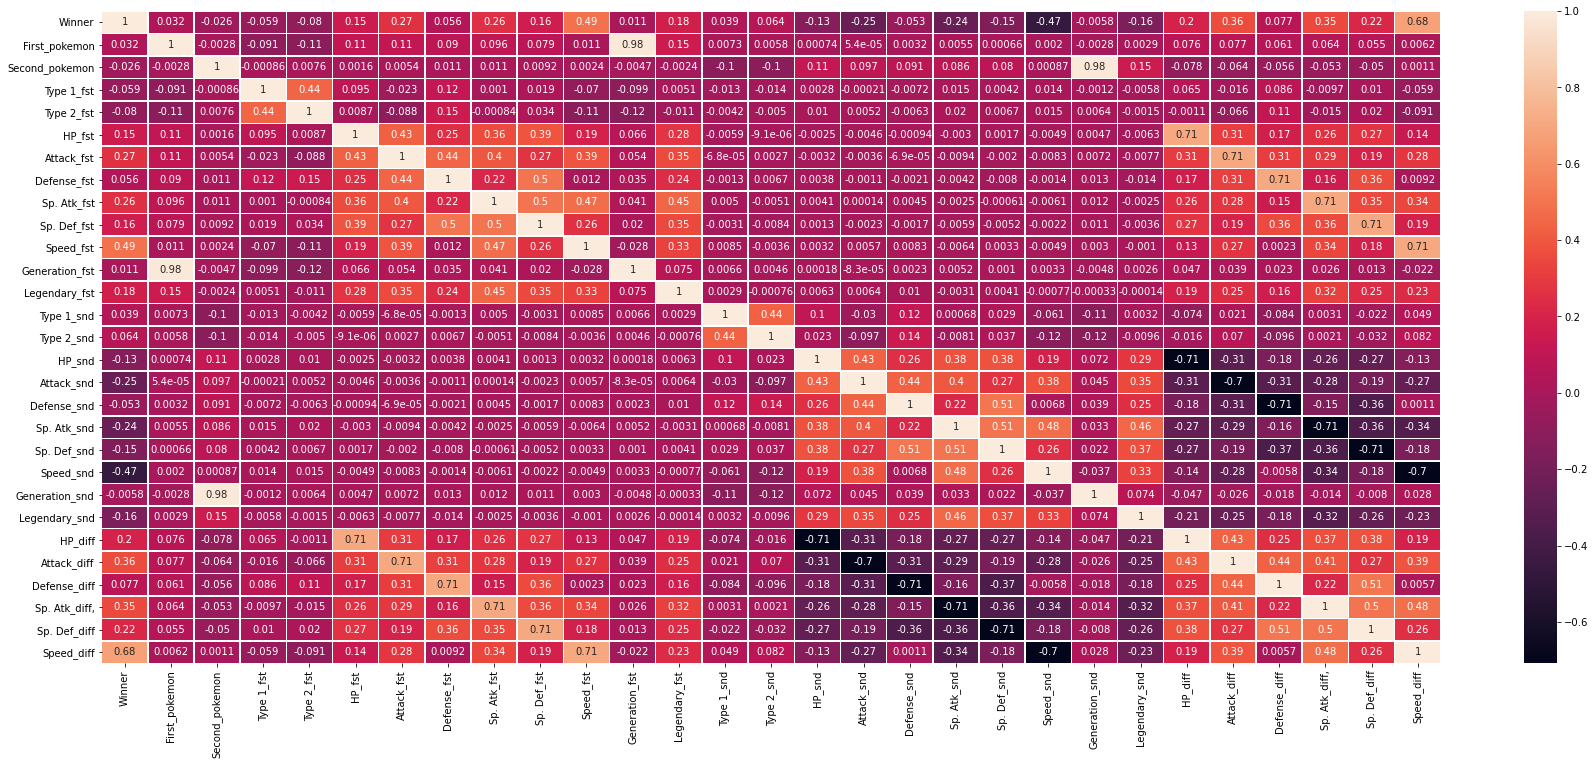

In [17]:
plt.figure(figsize=(30, 12))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot = True, linewidth = 0.5)
plt.show()

Di tutta la matrice, la colonna di particolare interesse è quella relativa alla label di classificazione "Winner" (Come già preannunciato).
Come si può notare dal grafico, le feature basate su differenze di statistiche dei pokémon associati a ciascun campione hanno mediamente una discreta influenza sull'esito della battaglia.
Da notare come la "Speed_diff" abbia correlazione particolarmente elevata con la label, suggerendo una notevole importanza della statistica al fine della determinazione dell'esito dello scontro, mentre "Def_diff" abbia molta poca rilevanza.

Scelgo come soglia di coefficiente di correlazione 0.1, considerando poco significative tutte le feature avente valore assoluto del suddetto coefficiente inferiore alla soglia.
Elimino dal dataset tali feature (First_pokemon, Second_pokemon, Type 1_fst, Type 2_fst, Defense_fst, Generation_fst, Type 1_snd, Type 2_snd, Defense_snd, Generation_snd, Defense_diff).

In [18]:
def drop_columns_generic(datasets: list, columns: list):
    for dataset in datasets:
        for column in columns:
            dataset.drop(columns=[f'{column}'], inplace = True, axis = 1)

In [19]:
drop_columns_generic([train_set, test_set], ['First_pokemon', 'Second_pokemon', 'Defense_diff'])
drop_columns([train_set, test_set], ['Type 1', 'Type 2', 'Defense', 'Generation', 'Legendary'])

Di conseguenza, ecco la heatmap corretta della matrice di correlazione, una volta effettuata una prima scrematura.

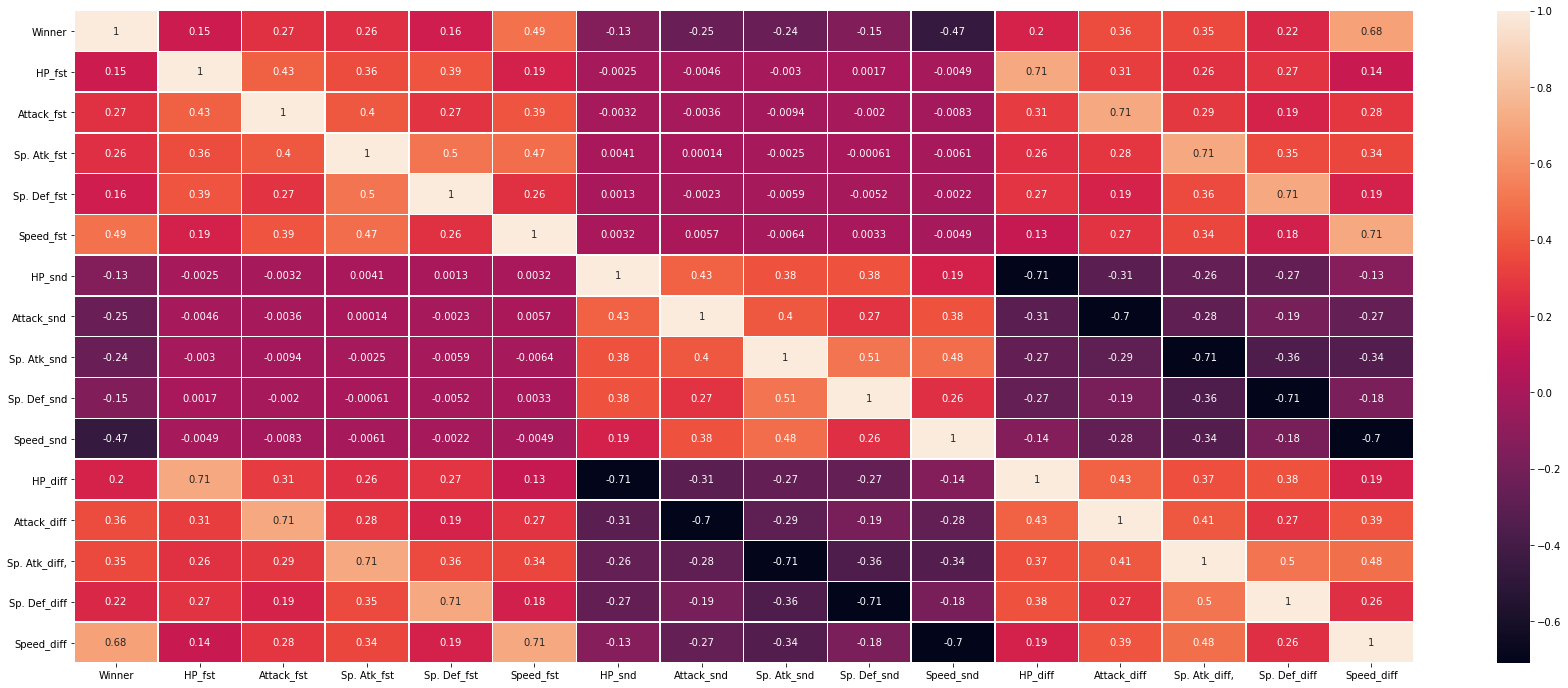

In [20]:
plt.figure(figsize=(30, 12))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot = True, linewidth = 0.5)
plt.show()

In [21]:
train_set.head()

,Winner,HP_fst,Attack_fst,Sp. Atk_fst,Sp. Def_fst,Speed_fst,HP_snd,Attack_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,HP_diff,Attack_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,1,100,90,45,65,55,70,105,50,40,20,30,-15,-5,25,35
1,1,55,55,85,55,30,70,105,50,40,20,-15,-50,35,15,10
2,1,100,100,150,140,90,70,105,50,40,20,30,-5,100,100,70
3,1,95,135,110,80,100,70,105,50,40,20,25,30,60,40,80
4,0,60,55,145,90,80,70,105,50,40,20,-10,-50,95,50,60


In [22]:
test_set.head()

,Winner,HP_fst,Attack_fst,Sp. Atk_fst,Sp. Def_fst,Speed_fst,HP_snd,Attack_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,HP_diff,Attack_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,1,70,120,45,85,125,75,69,114,100,104,-5,51,-69,-15,21
1,0,95,110,70,80,50,75,69,114,100,104,20,41,-44,-20,-54
2,0,60,30,36,56,50,75,69,114,100,104,-15,-39,-78,-44,-54
3,0,85,120,50,60,100,75,69,114,100,104,10,51,-64,-40,-4
4,0,83,106,86,65,85,75,69,114,100,104,8,37,-28,-35,-19


Training

Preparo i dati per l'addestramento, ovvero estraggo la label target ("Winner") dai dataset, in modo da poter applicare algoritmi di apprendimento supervisionato, in modo da realizzare un modello che sia in grado di determinare il valore eliminato a monte con la massima accuratezza possibile.

In [23]:
X_train = train_set.copy()
y_train = X_train.pop('Winner')

X_test = test_set.copy()
y_test = X_test.pop('Winner')

Alleno il modello 10 volte (in modo da poter osservare quanto un fattore randomico possa influire sull'allenamento) e calcolo l'accuracy sulla predict degli elementi del test_set. 

In [25]:
dtree = tree.DecisionTreeClassifier()
dtree_results = []

for i in range(10):
    dtree.fit(X_train, y_train)

    y_train_pred=dtree.predict(X_train)
    y_test_pred=dtree.predict(X_test)

    train_accuracy, test_accuracy = round(accuracy_score(y_train, y_train_pred)*100, 2), round(accuracy_score(y_test, y_test_pred)*100, 2)
    dtree_results.append(test_accuracy)

    print(f"Decision Tree Classifier")
    print(f"Training Accuracy = {train_accuracy}%")
    print(f"Test Accuracy = {test_accuracy}%\n")

best_result = max(dtree_results)
worst_result = min(dtree_results)
print(f'Results over 10 iterations = {dtree_results}')
print(f'Best result = {best_result}%')
print(f'Worst result = {worst_result}%')


Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.6%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.82%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.98%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.56%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.69%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.8%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.78%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.84%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.46%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.65%

Results over 10 iterations = [91.6, 91.82, 91.98, 91.56, 91.69, 91.8, 91.78, 91.84, 91.46, 91.65]
Best result = 91.98%
Worst result = 91.46%


Di seguito, la matrice di confusione dell'ultimo modello allenato(per semplicità, dato che non sembra esserci molta varianza), che ci permette di quantificare quanti errori di tipo 1 e 2 il classificatore abbia commesso.

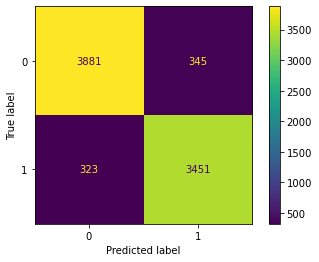

In [26]:
plot_confusion_matrix(dtree, X_test, y_test, values_format='n', display_labels=['0','1'])
plt.show() 

Drop di nuove feature
Provo ad alzare la soglia di coefficiente di correlazione a 0.2. Questo si traduce nell'eliminazione di altre 4 feature: "HP_fst", "HP_snd", "Sp. Def_fst" e "Sp. Def_snd".
Effettuo esattamente gli stessi passaggi di prima, con i nuovi train e test set.


In [27]:
drop_columns([train_set, test_set], ['HP', 'Sp. Def'])

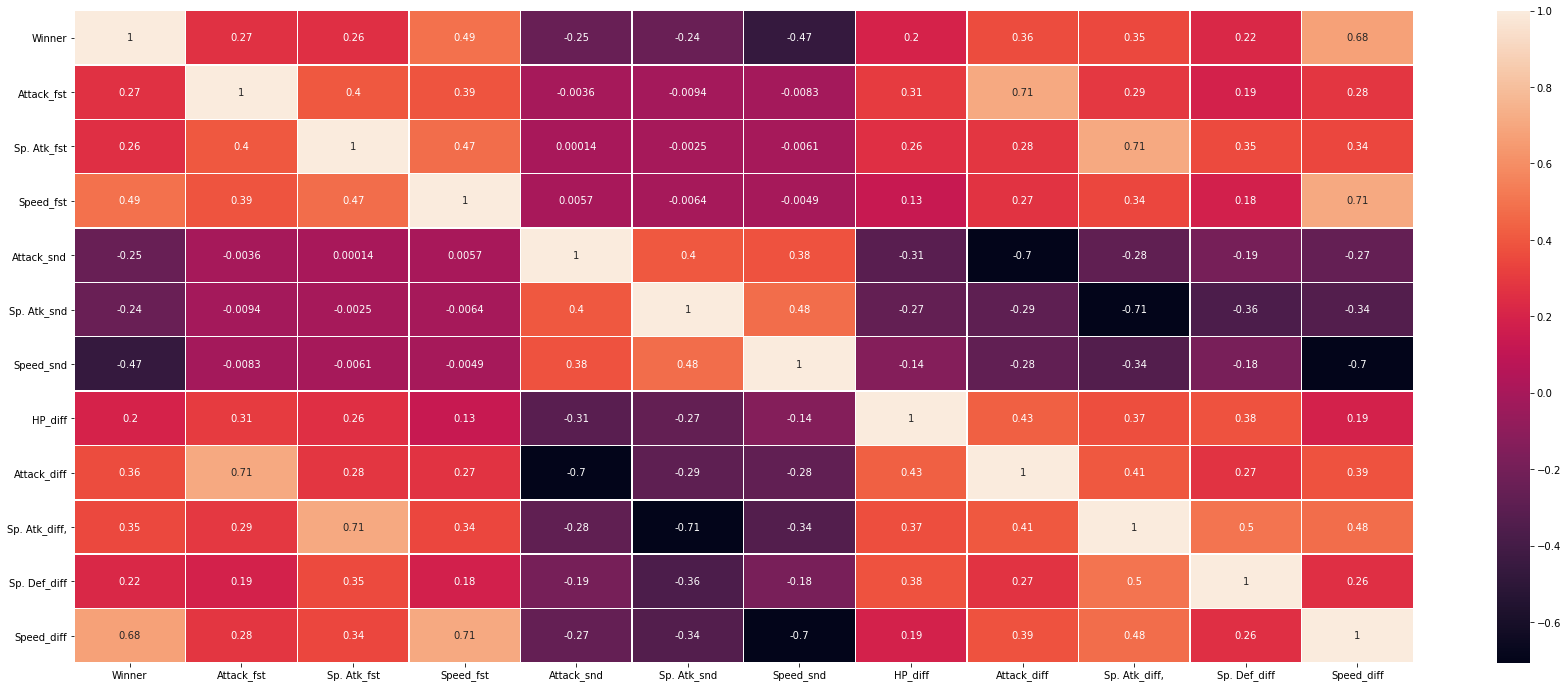

In [28]:
plt.figure(figsize=(30, 12))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot = True, linewidth = 0.5)
plt.show()

In [29]:
dtree_less_f = tree.DecisionTreeClassifier()
dtree_results_less_f = []

for i in range(10):
    dtree_less_f.fit(X_train, y_train)

    y_train_pred=dtree_less_f.predict(X_train)
    y_test_pred=dtree_less_f.predict(X_test)
    dtree_results_less_f.append(test_accuracy)

    train_accuracy, test_accuracy = round(accuracy_score(y_train, y_train_pred)*100, 2), round(accuracy_score(y_test, y_test_pred)*100, 2)

    print(f"Decision Tree Classifier with less features")
    print(f"Training Accuracy = {train_accuracy}%")
    print(f"Test Accuracy = {test_accuracy}%\n")
best_result_less_f = max(dtree_results_less_f)
worst_result_less_f = min(dtree_results_less_f)
print(f'Results over 10 iterations = {dtree_results_less_f}')
print(f'Best result = {best_result_less_f}%')
print(f'Worst result = {worst_result_less_f}%')

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.71%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.82%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.95%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.61%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.84%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.85%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.76%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.76%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.66%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.8%

Results over 10 iterations = [91.65, 91.71, 91.82, 

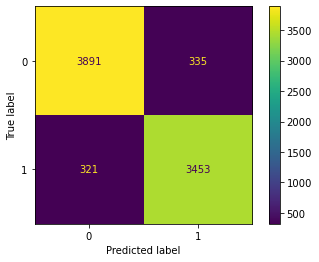

In [30]:
plot_confusion_matrix(dtree_less_f, X_test, y_test, values_format='n', display_labels=['0','1'])
plt.show() 

In [31]:
results = pd.DataFrame({
    'Model': ['Decision Tree(15_features)', 'Decision Tree(11_features)'],
    'Best Results': [best_result, best_result_less_f],
    'Worst Results': [worst_result, worst_result_less_f]
})
results.sort_values(by='Best Results', ascending=False)

,Model,Best Results,Worst Results
0,Decision Tree(15_features),91.98,91.46
1,Decision Tree(11_features),91.95,91.61


Come si può vedere dalla tabella sopra riportata, la scelta di escludere anche le feature relative ad HP e Sp. Def sembra essersi rivelata corretta, essendo riuscita a migliorare (anche se marginalmente) il risultato della classificazione). Non è da escludere, tuttavia, che il miglioramento sia solo dovuto alla randomicita, essendo i valori così poco differenti. In ogni caso il contributo delle quattro feature rimosse è considerabile irrisorio al fine della classificazione.

Eliminare altre feature causerebbe perdite di prestazioni.